In [ ]:
# Remember to mount your Google Drive before proceeding!
!pip install -i https://test.pypi.org/simple/ resnet-simple -q
!pip install nvidia-ml-py -q

In [ ]:
%load_ext tensorboard
%matplotlib inline
import torch
import random
import pynvml
import matplotlib.pyplot as plt
from torch import optim
from tqdm.auto import tqdm
from sklearn import metrics
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from resnet_simple import ResNet50, ResNetPredictor

# To insert your own folder directory
MODEL_FOLDER = "Models/"

def calculate_gpu_utilization(gpu_index: int = 0):
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(gpu_index)
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used // 1024 ** 2} MB.")

# Train ResNet

In [ ]:
# Data augmentation to reduce overfitting
# Calculations for mean and std values: https://github.com/Armour/pytorch-nn-practice/blob/master/utils/meanstd.py
mean, std = [0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]
batch_size = 256
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomCrop(32, padding = 4),
    transforms.RandAugment(num_ops = 2, magnitude = 9),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train = datasets.CIFAR10(root = "sample_data/cifar", download = True, train = True, transform = transform_train)
trainloader = DataLoader(train, batch_size = batch_size, shuffle = True)

test = datasets.CIFAR10(root = "sample_data/cifar", download = True, train = False, transform = transform_test)
testloader = DataLoader(test, batch_size = batch_size)

calculate_gpu_utilization(0)

Files already downloaded and verified
Files already downloaded and verified
GPU memory occupied: 258 MB.


In [ ]:
resnet = ResNet50()

# Modelling most of the hyperparameters from https://catalog.ngc.nvidia.com/orgs/nvidia/teams/dle/resources/resnet_pyt
episodes = 200
optimizer = optim.SGD(
    resnet.parameters(),
    lr = batch_size / 1000, # linearly scale lr based on batch_size: https://arxiv.org/pdf/1706.02677.pdf%5B3%5D%20ImageNet
    momentum = 0.875,
    weight_decay = 1/32768
)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max = episodes
)

resnet_classifier = ResNetPredictor(
    resnet,
    optimizer = optimizer,
    lr_scheduler = lr_scheduler,
    mode = "single_label_classification",
    num_classes = len(train.classes),
    dropout = 0.2,
    optimize_predictor = True
)

In [ ]:
writer = SummaryWriter()
episode_bar = tqdm(range(episodes))
for episode in episode_bar:
    print(f"[Episode {episode + 1}]")
    # Train model using train data
    y_true, y_pred, loss = resnet_classifier.step(trainloader, training = True)
    accuracy = metrics.accuracy_score(y_true, y_pred) * 100
    print(f"Train Loss: {loss}")
    print(f"Train Accuracy: {accuracy}%")
    episode_bar.set_description(f"Train Loss: {loss}")
    writer.add_scalar("Train Loss (with Dropout)", loss, episode)
    writer.add_scalar("Train Accuracy (with Dropout)", accuracy, episode)

    # Evaluate every 5 epochs
    if (episode + 1) % 5 == 0:
        # Evaluate model using test data
        y_true, y_pred, loss = resnet_classifier.step(testloader, training = False)
        accuracy = metrics.accuracy_score(y_true, y_pred) * 100
        print(f"Test Loss: {loss}")
        print(f"Test Accuracy: {accuracy}%")
        writer.add_scalar("Test Loss (without Dropout)", loss, episode)
        writer.add_scalar("Test Accuracy (without Dropout)", accuracy, episode)

    # Write last learning rate to log
    writer.add_scalar("Learning Rate", lr_scheduler.get_last_lr()[0], episode)

    # Save model every 10 epochs
    if (episode + 1) % 10 == 0:
        resnet_classifier.save(MODEL_FOLDER + f"resnet50_cifar10_episode{episode + 1}.safetensors")

calculate_gpu_utilization(0)
writer.flush()
writer.close()
%tensorboard --logdir=runs

  0%|          | 0/200 [00:00<?, ?it/s]

[Episode 1]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 5.568903440084213
Train Accuracy: 10.363999999999999%
[Episode 2]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 2.2789242573273487
Train Accuracy: 13.388%
[Episode 3]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 2.255759321114956
Train Accuracy: 14.457999999999998%
[Episode 4]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 2.2286734495407496
Train Accuracy: 15.584000000000001%
[Episode 5]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 2.1934854972056854
Train Accuracy: 16.566%


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 2.2153872893406796
Test Accuracy: 17.919999999999998%
[Episode 6]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 2.1709237379905506
Train Accuracy: 16.866%
[Episode 7]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 2.1572138554010634
Train Accuracy: 17.25%
[Episode 8]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 2.141887716146616
Train Accuracy: 17.764%
[Episode 9]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 2.120186304434752
Train Accuracy: 19.522000000000002%
[Episode 10]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 2.096274786729079
Train Accuracy: 20.654%


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 2.1075888872146606
Test Accuracy: 23.14%
[Episode 11]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 2.0802972170022818
Train Accuracy: 21.582%
[Episode 12]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 2.0669949751633863
Train Accuracy: 22.695999999999998%
[Episode 13]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 2.053791648302323
Train Accuracy: 23.384%
[Episode 14]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 2.043713702299656
Train Accuracy: 23.764%
[Episode 15]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 2.0323331319368805
Train Accuracy: 24.444%


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 2.023396446154668
Test Accuracy: 26.21%
[Episode 16]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 2.0177790592878293
Train Accuracy: 25.222%
[Episode 17]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 2.0137522648542356
Train Accuracy: 25.798%
[Episode 18]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.9908864106887425
Train Accuracy: 26.656000000000002%
[Episode 19]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.986715070406596
Train Accuracy: 26.962000000000003%
[Episode 20]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.9732180833816528
Train Accuracy: 28.014%


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.986976030545357
Test Accuracy: 32.190000000000005%
[Episode 21]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.966865192926847
Train Accuracy: 28.52%
[Episode 22]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.9566695849100748
Train Accuracy: 29.365999999999996%
[Episode 23]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.9508097801453028
Train Accuracy: 30.378%
[Episode 24]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.9380514273276697
Train Accuracy: 31.34%
[Episode 25]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.9214425025842128
Train Accuracy: 31.982%


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.9138273214682555
Test Accuracy: 37.57%
[Episode 26]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.913947160427387
Train Accuracy: 33.1%
[Episode 27]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.901485279890207
Train Accuracy: 33.858%
[Episode 28]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.894053689027444
Train Accuracy: 34.158%
[Episode 29]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.874976603190104
Train Accuracy: 35.152%
[Episode 30]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.8643407564896803
Train Accuracy: 35.838%


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.81703235858526
Test Accuracy: 41.47%
[Episode 31]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.8637665980901474
Train Accuracy: 36.19%
[Episode 32]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.836526728899051
Train Accuracy: 37.71%
[Episode 33]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.9445774163955296
Train Accuracy: 31.619999999999997%
[Episode 34]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.8658405493467283
Train Accuracy: 35.931999999999995%
[Episode 35]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.8400649779882186
Train Accuracy: 37.354%


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.8263892027047963
Test Accuracy: 41.699999999999996%
[Episode 36]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.8280615733220027
Train Accuracy: 38.162%
[Episode 37]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.8118140294001652
Train Accuracy: 39.214%
[Episode 38]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.7999381059255355
Train Accuracy: 39.702%
[Episode 39]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.7834905807788555
Train Accuracy: 40.89%
[Episode 40]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.7648401700533354
Train Accuracy: 41.85%


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.7119083832471798
Test Accuracy: 46.28%
[Episode 41]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.7547134662285828
Train Accuracy: 42.348%
[Episode 42]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.7489450130707178
Train Accuracy: 43.004%
[Episode 43]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.733431025651785
Train Accuracy: 43.66%
[Episode 44]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.725669850447239
Train Accuracy: 44.384%
[Episode 45]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.715968666321192
Train Accuracy: 44.87%


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.6460754321171687
Test Accuracy: 49.29%
[Episode 46]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.7089390424581674
Train Accuracy: 45.482%
[Episode 47]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.6950710449463282
Train Accuracy: 46.024%
[Episode 48]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.6835330376258264
Train Accuracy: 46.842%
[Episode 49]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.675188406308492
Train Accuracy: 47.062%
[Episode 50]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.6633294417307927
Train Accuracy: 47.760000000000005%


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.6002687185238569
Test Accuracy: 53.02%
[Episode 51]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.6504338790208866
Train Accuracy: 48.504000000000005%
[Episode 52]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.6420179397631913
Train Accuracy: 48.894%
[Episode 53]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.633595815071693
Train Accuracy: 49.065999999999995%
[Episode 54]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.6193703388556455
Train Accuracy: 50.32%
[Episode 55]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.6169326348182482
Train Accuracy: 50.23800000000001%


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.540889458778577
Test Accuracy: 56.330000000000005%
[Episode 56]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.6008430707149017
Train Accuracy: 50.956%
[Episode 57]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.596072690303509
Train Accuracy: 51.074%
[Episode 58]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.588963624758598
Train Accuracy: 51.456%
[Episode 59]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.5793437639872232
Train Accuracy: 52.074%
[Episode 60]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.9064713716506958
Train Accuracy: 34.952%


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.7012237218710093
Test Accuracy: 46.57%
[Episode 61]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.7715108736967429
Train Accuracy: 41.827999999999996%
[Episode 62]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.7142562578885983
Train Accuracy: 45.076%
[Episode 63]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.6741777951900776
Train Accuracy: 46.948%
[Episode 64]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.6502699833649856
Train Accuracy: 48.16%
[Episode 65]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.6200948250599396
Train Accuracy: 49.797999999999995%


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.493564559863164
Test Accuracy: 56.81%
[Episode 66]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.5988603060062114
Train Accuracy: 50.688%
[Episode 67]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.5883003687247252
Train Accuracy: 51.571999999999996%
[Episode 68]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.5724594886486347
Train Accuracy: 51.906%
[Episode 69]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.5605086296032638
Train Accuracy: 52.803999999999995%
[Episode 70]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.5475012449117806
Train Accuracy: 53.142%


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.4195204912087855
Test Accuracy: 60.660000000000004%
[Episode 71]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.5390480927931958
Train Accuracy: 53.896%
[Episode 72]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.5261357069015502
Train Accuracy: 54.478%
[Episode 73]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.5160901424212334
Train Accuracy: 54.901999999999994%
[Episode 74]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.504718983479035
Train Accuracy: 55.346%
[Episode 75]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.4938620041578243
Train Accuracy: 55.952%


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.3981068501105676
Test Accuracy: 61.73%
[Episode 76]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.4845593165128659
Train Accuracy: 56.376000000000005%
[Episode 77]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.4759385445179083
Train Accuracy: 57.02%
[Episode 78]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.4634107485795633
Train Accuracy: 57.346%
[Episode 79]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.4607826336836203
Train Accuracy: 57.599999999999994%
[Episode 80]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.4510926344455817
Train Accuracy: 58.001999999999995%


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.459635398326776
Test Accuracy: 63.629999999999995%
[Episode 81]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.4378111399137057
Train Accuracy: 58.668%
[Episode 82]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.4371795189686312
Train Accuracy: 58.562000000000005%
[Episode 83]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.4322584353960477
Train Accuracy: 58.992%
[Episode 84]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.4182832369437584
Train Accuracy: 59.484%
[Episode 85]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.42150042790633
Train Accuracy: 59.248%


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.5437354644139607
Test Accuracy: 65.38000000000001%
[Episode 86]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.406055941948524
Train Accuracy: 59.98%
[Episode 87]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.4018156418433556
Train Accuracy: 60.012%
[Episode 88]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.393939749399821
Train Accuracy: 60.572%
[Episode 89]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.3940172751744588
Train Accuracy: 60.67399999999999%
[Episode 90]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.381997821881221
Train Accuracy: 61.108%


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.383281340965858
Test Accuracy: 67.07%
[Episode 91]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.3725477383686946
Train Accuracy: 61.550000000000004%
[Episode 92]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.3692251205444337
Train Accuracy: 61.565999999999995%
[Episode 93]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.3608369992329523
Train Accuracy: 61.916000000000004%
[Episode 94]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.358790091979198
Train Accuracy: 62.344%
[Episode 95]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.3526440070225643
Train Accuracy: 62.548%


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.3658372438870943
Test Accuracy: 68.03%
[Episode 96]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.3442108979591956
Train Accuracy: 62.904%
[Episode 97]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.469246693757864
Train Accuracy: 57.054%
[Episode 98]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.3616076548894247
Train Accuracy: 61.919999999999995%
[Episode 99]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.3428612482853426
Train Accuracy: 62.818%
[Episode 100]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Train Loss: 1.3355458290149005
Train Accuracy: 63.080000000000005%


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.3448216792864678
Test Accuracy: 68.76%
[Episode 101]


Training:   0%|          | 0/196 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

# Evaluate ResNet

In [ ]:
mean, std = [0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]
batch_size = 256
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

inverse_transform = transforms.Compose([
    transforms.Normalize([-m/s for m, s in zip(mean, std)], [1/s for s in std]),
    transforms.ToPILImage()
])

test = datasets.CIFAR10(root = "sample_data/cifar", download = True, train = False, transform = transform_test)
testloader = DataLoader(test, batch_size = batch_size)

resnet = ResNet50()
resnet_classifier = ResNetPredictor(
    resnet,
    mode = "single_label_classification",
    num_classes = len(test.classes),
    dropout = 0.0
)

# Load and test model from episode 100
resnet_classifier.load(MODEL_FOLDER + "resnet50_cifar10_episode100.safetensors")
y_true, y_pred, loss = resnet_classifier.step(testloader, training = False)

# Calculate metrics
accuracy = metrics.accuracy_score(y_true, y_pred) * 100
f1_score = metrics.f1_score(y_true, y_pred, average = "macro") * 100
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}%")
print(f"Test F1-Score: {f1_score}%")

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.3448216792864678
Test Accuracy: 68.76%
Test F1-Score: 68.52733851395001%


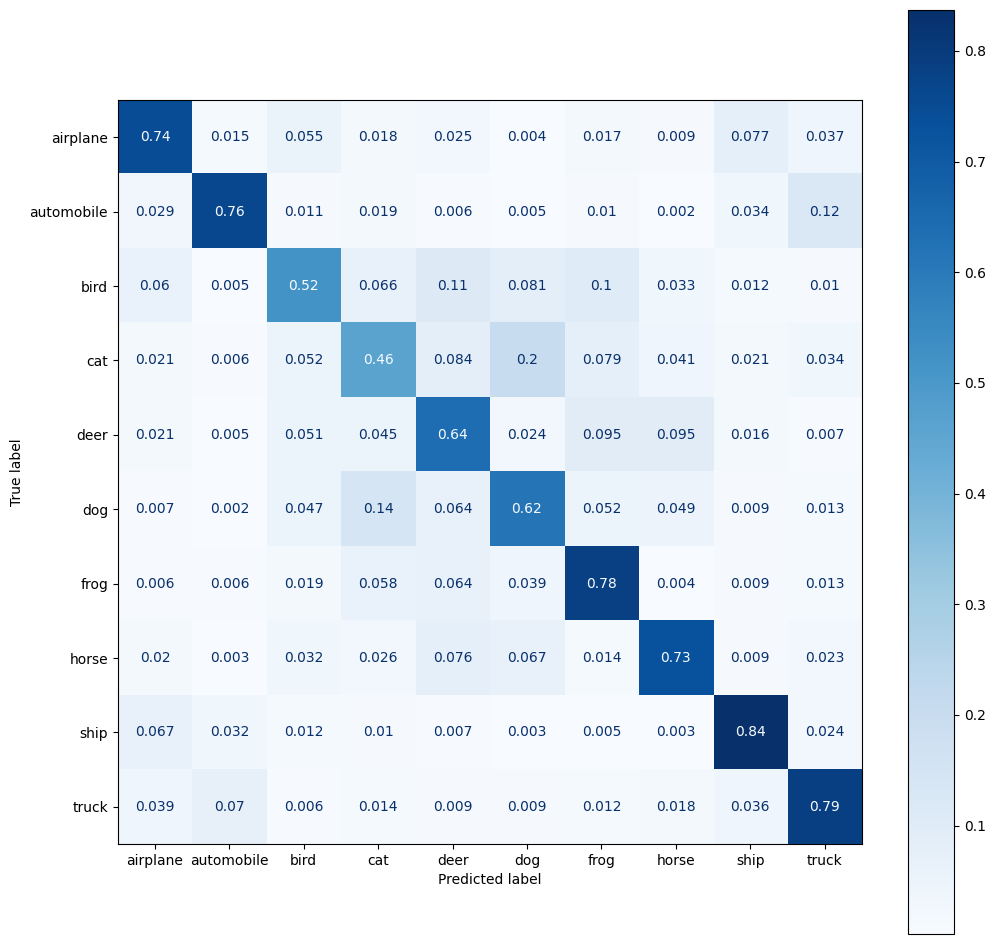

In [ ]:
# Confusion matrix
fig, ax = plt.subplots(figsize = (12, 12))
display = metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels = [i for i in range(len(test.classes))], normalize = "true", display_labels = test.classes, cmap = plt.cm.Blues, ax = ax) # normalize over true conditions
plt.show()

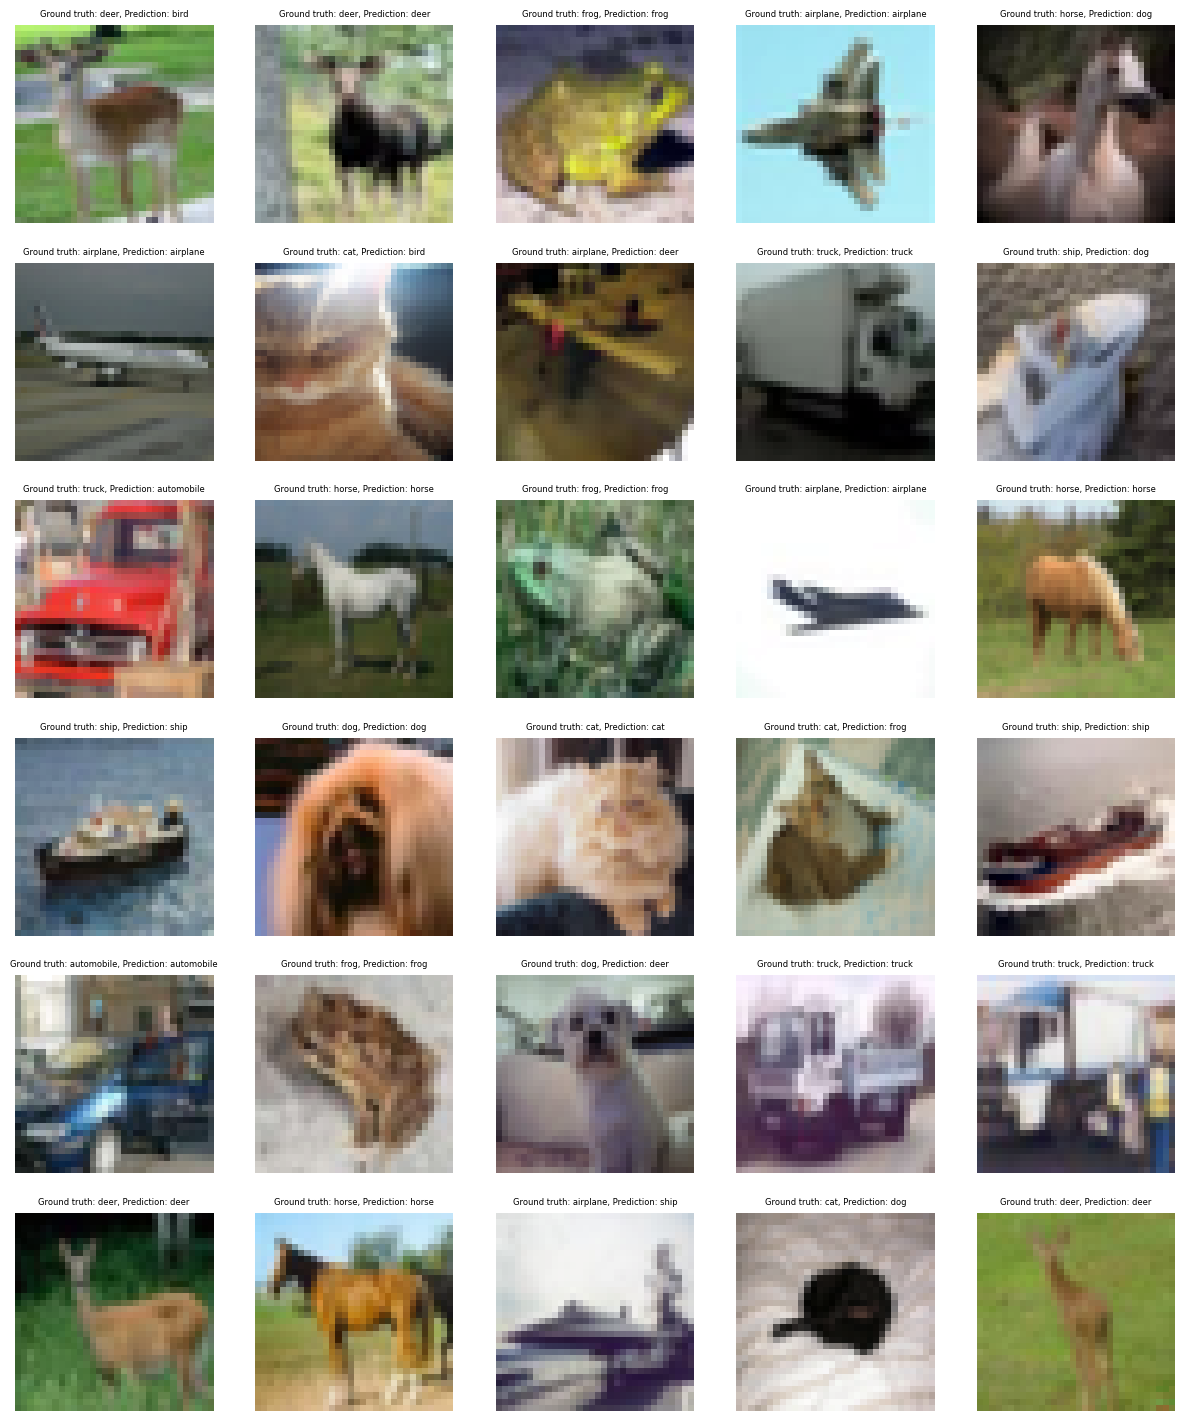

In [ ]:
# Visualize tagging of predicted labels to their images
rows, cols, scale = 6, 5, 3
figure = plt.figure(figsize = (cols * scale, rows * scale))
plt.rc("font", size = 5)

for i in range(rows * cols):
    rand_index = random.randint(0, len(y_true) - 1)
    ax = figure.add_subplot(rows, cols, i + 1)
    ax.set_title(f"Ground truth: {test.classes[y_true[rand_index]]}, Prediction: {test.classes[y_pred[rand_index]]}")
    ax.axis("off")
    ax.imshow(inverse_transform(test[rand_index][0])) # only works if we do not shuffle test dataset
plt.show()